In [ ]:
# Titanic Classification
# Make a system which tells whether the person will be save from sinking. 
# What factors were most likely lead to success-socio-economic status, age, gender and more.

In [43]:
# Importing necessary libraries
import pandas as pd
import numpy as np

In [44]:
# Load the dataset 
train_data = pd.read_csv("Downloads/train.csv")
test_data = pd.read_csv("Downloads/test.csv")

In [45]:
# summary of data 
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


In [46]:
# summary of data
test_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  418 non-null    int64  
 1   Pclass       418 non-null    int64  
 2   Name         418 non-null    object 
 3   Sex          418 non-null    object 
 4   Age          332 non-null    float64
 5   SibSp        418 non-null    int64  
 6   Parch        418 non-null    int64  
 7   Ticket       418 non-null    object 
 8   Fare         417 non-null    float64
 9   Cabin        91 non-null     object 
 10  Embarked     418 non-null    object 
dtypes: float64(2), int64(4), object(5)
memory usage: 36.1+ KB


In [47]:
# copy of train_data
train_data_copy = train_data

In [48]:
# Looking for null values
train_data_copy.isna().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

In [49]:
# satistical summary of data
train_data_copy.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


In [50]:
# Handling missing values in embarked with the max value
highest_embarked = train_data_copy['Embarked'].value_counts().idxmax()
train_data_copy['Embarked'].fillna(highest_embarked, inplace=True)

# Converting into numeric values
train_data_copy['Embarked'] = train_data_copy['Embarked'].map({'S': 0, 'C': 1, 'Q': 2})

In [51]:
# Filling the missing values in age with mean values
groups = [['Pclass', 'Sex', 'Parch', 'SibSp'], ['Pclass', 'Sex', 'Parch'], ['Pclass', 'Sex']]
for group in groups:
    train_data_copy['Age'] = train_data_copy.groupby(group)['Age'].transform(lambda x: x.fillna(x.mean()))
train_data_copy['Age'] = train_data_copy['Age'].fillna(train_data_copy['Age'].mean())

In [52]:
# Fill the missing value of cabin with U
train_data_copy['Cabin'].fillna('U', inplace=True)

In [53]:
# Extracting titles from name and replacing it with numeric values
train_data_copy['Title'] = train_data_copy['Name'].str.extract(' ([A-Za-z]+)\.', expand=False)
train_data_copy['Title'] = train_data_copy['Title'].replace(['Lady', 'the Countess', 'Countess', 'Capt', 'Col', 'Don', 'Dr', 'Major', 'Rev', 'Sir', 'Jonkheer', 'Dona'], 'Rare')
train_data_copy['Title'] = train_data_copy['Title'].replace(['Mlle', 'Ms'], 'Miss').replace('Mme', 'Mrs')
train_data_copy['Title'] = train_data_copy['Title'].map({"Mr": 1, "Miss": 2, "Mrs": 3, "Master": 4, "Rare": 5})

In [54]:
# Calculate the family size by adding siblings,spouse and parentchild 
train_data_copy['FamilySize'] = train_data_copy['SibSp'] + train_data_copy['Parch'] + 1

In [55]:
# create a column alone for single persons
train_data_copy['Alone'] = (train_data_copy['FamilySize'] == 1).astype(int)

# create a column child for children 
train_data_copy['Child'] = (train_data_copy['Age'] < 18).astype(int)

In [56]:
# Extracting the 1st letter of cabin and converting it into numeri values
train_data_copy['Cabin'] = train_data_copy['Cabin'].str[:1]
cabin_mapping = {cabin: i for i, cabin in enumerate(set(train_data_copy['Cabin']))}
train_data_copy['Cabin'] = train_data_copy['Cabin'].map(cabin_mapping)

In [57]:
# checks the survivor among passenger with same ticket number
train_data_copy['TicketSurvivor'] = 0
ticket_counts = train_data_copy['Ticket'].value_counts().to_dict()
for ticket, count in ticket_counts.items():
    if count > 1:
        survivors = train_data_copy['Survived'][train_data_copy['Ticket'] == ticket].sum()
        if survivors > 0:
            train_data_copy.loc[train_data_copy['Ticket'] == ticket, 'TicketSurvivor'] = 1

In [58]:
# Droping unnesscary column 
train_data_copy = train_data_copy.drop(['Name', 'Ticket', 'PassengerId'], axis=1)

# converting sex to numeric values
train_data_copy['Sex'] = train_data_copy['Sex'].map({'male': 0, 'female': 1})

# print 1st few columns
train_data_copy.head(10)

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Cabin,Embarked,Title,FamilySize,Alone,Child,TicketSurvivor
0,0,3,0,22.000000,1,0,7.2500,6,0,1,2,0,0,0
1,1,1,1,38.000000,1,0,71.2833,1,1,3,2,0,0,0
2,1,3,1,26.000000,0,0,7.9250,6,0,2,1,1,0,0
3,1,1,1,35.000000,1,0,53.1000,1,0,3,2,0,0,1
4,0,3,0,35.000000,0,0,8.0500,6,0,1,1,1,0,0
5,0,3,0,29.184492,0,0,8.4583,6,2,1,1,1,0,0
6,0,1,0,54.000000,0,0,51.8625,8,0,1,1,1,0,0
7,0,3,0,2.000000,3,1,21.0750,6,0,4,5,0,1,0
8,1,3,1,27.000000,0,2,11.1333,6,0,3,3,0,0,1
9,1,2,1,14.000000,1,0,30.0708,6,1,3,2,0,1,1


In [59]:
# coping data
train_df = train_data_copy.copy()

# setting target variable 
X = train_df.drop(['Survived'], axis = 1)
y = train_df['Survived']

#standarizing
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
X = pd.DataFrame(sc.fit_transform(X.values), index=X.index, columns=X.columns)

In [60]:
from sklearn.model_selection import train_test_split
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [61]:
# SVM
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score

# Initialize the model
svm_model = SVC(kernel='linear', probability=True, random_state=42)

# Train the model
svm_model.fit(X_train, y_train)

# Predict on the test set
y_pred_svm = svm_model.predict(X_test)

# Evaluate the model
accuracy_svm = accuracy_score(y_test, y_pred_svm)
precision_svm = precision_score(y_test, y_pred_svm)
recall_svm = recall_score(y_test, y_pred_svm)
f1_svm = f1_score(y_test, y_pred_svm)
roc_auc_svm = roc_auc_score(y_test, y_pred_svm)

print("Support Vector Machine")
print(f"Accuracy: {accuracy_svm:.4f}")
print(f"Precision: {precision_svm:.4f}")
print(f"Recall: {recall_svm:.4f}")
print(f"F1 Score: {f1_svm:.4f}")
print(f"ROC-AUC: {roc_auc_svm:.4f}")

Support Vector Machine
Accuracy: 0.8156
Precision: 0.8475
Recall: 0.6757
F1 Score: 0.7519
ROC-AUC: 0.7950


In [62]:
# Gradient Boosting Classifier 
from sklearn.ensemble import GradientBoostingClassifier

# Initialize the model
gbc_model = GradientBoostingClassifier(n_estimators=100, random_state=42)

# Train the model
gbc_model.fit(X_train, y_train)

# Predict on the test set
y_pred_gbc = gbc_model.predict(X_test)

# Evaluate the model
accuracy_gbc = accuracy_score(y_test, y_pred_gbc)
precision_gbc = precision_score(y_test, y_pred_gbc)
recall_gbc = recall_score(y_test, y_pred_gbc)
f1_gbc = f1_score(y_test, y_pred_gbc)
roc_auc_gbc = roc_auc_score(y_test, y_pred_gbc)

print("Gradient Boosting Classifier")
print(f"Accuracy: {accuracy_gbc:.4f}")
print(f"Precision: {precision_gbc:.4f}")
print(f"Recall: {recall_gbc:.4f}")
print(f"F1 Score: {f1_gbc:.4f}")
print(f"ROC-AUC: {roc_auc_gbc:.4f}")


Gradient Boosting Classifier
Accuracy: 0.8827
Precision: 0.9077
Recall: 0.7973
F1 Score: 0.8489
ROC-AUC: 0.8701


In [63]:
#KNN
from sklearn.neighbors import KNeighborsClassifier

# Initialize the model
knn_model = KNeighborsClassifier(n_neighbors=5)

# Train the model
knn_model.fit(X_train, y_train)

# Predict on the test set
y_pred_knn = knn_model.predict(X_test)

# Evaluate the model
accuracy_knn = accuracy_score(y_test, y_pred_knn)
precision_knn = precision_score(y_test, y_pred_knn)
recall_knn = recall_score(y_test, y_pred_knn)
f1_knn = f1_score(y_test, y_pred_knn)
roc_auc_knn = roc_auc_score(y_test, y_pred_knn)

print("K-Nearest Neighbors")
print(f"Accuracy: {accuracy_knn:.4f}")
print(f"Precision: {precision_knn:.4f}")
print(f"Recall: {recall_knn:.4f}")
print(f"F1 Score: {f1_knn:.4f}")
print(f"ROC-AUC: {roc_auc_knn:.4f}")


K-Nearest Neighbors
Accuracy: 0.8659
Precision: 0.8788
Recall: 0.7838
F1 Score: 0.8286
ROC-AUC: 0.8538


In [64]:
# Decision Tree Classifier
from sklearn.tree import DecisionTreeClassifier

# Initialize the model
dt_model = DecisionTreeClassifier(random_state=42)

# Train the model
dt_model.fit(X_train, y_train)

# Predict on the test set
y_pred_dt = dt_model.predict(X_test)

# Evaluate the model
accuracy_dt = accuracy_score(y_test, y_pred_dt)
precision_dt = precision_score(y_test, y_pred_dt)
recall_dt = recall_score(y_test, y_pred_dt)
f1_dt = f1_score(y_test, y_pred_dt)
roc_auc_dt = roc_auc_score(y_test, y_pred_dt)

print("Decision Tree Classifier")
print(f"Accuracy: {accuracy_dt:.4f}")
print(f"Precision: {precision_dt:.4f}")
print(f"Recall: {recall_dt:.4f}")
print(f"F1 Score: {f1_dt:.4f}")
print(f"ROC-AUC: {roc_auc_dt:.4f}")


Decision Tree Classifier
Accuracy: 0.8156
Precision: 0.7595
Recall: 0.8108
F1 Score: 0.7843
ROC-AUC: 0.8149


In [65]:
# Naive_bayes 
from sklearn.naive_bayes import GaussianNB

# Initialize the model
nb_model = GaussianNB()

# Train the model
nb_model.fit(X_train, y_train)

# Predict on the test set
y_pred_nb = nb_model.predict(X_test)

# Evaluate the model
accuracy_nb = accuracy_score(y_test, y_pred_nb)
precision_nb = precision_score(y_test, y_pred_nb)
recall_nb = recall_score(y_test, y_pred_nb)
f1_nb = f1_score(y_test, y_pred_nb)
roc_auc_nb = roc_auc_score(y_test, y_pred_nb)

print("Naive Bayes")
print(f"Accuracy: {accuracy_nb:.4f}")
print(f"Precision: {precision_nb:.4f}")
print(f"Recall: {recall_nb:.4f}")
print(f"F1 Score: {f1_nb:.4f}")
print(f"ROC-AUC: {roc_auc_nb:.4f}")


Naive Bayes
Accuracy: 0.7654
Precision: 0.7286
Recall: 0.6892
F1 Score: 0.7083
ROC-AUC: 0.7541


In [66]:
from sklearn.ensemble import AdaBoostClassifier

# Initialize the model
ab_model = AdaBoostClassifier(n_estimators=100, random_state=42)

# Train the model
ab_model.fit(X_train, y_train)

# Predict on the test set
y_pred_ab = ab_model.predict(X_test)

# Evaluate the model
accuracy_ab = accuracy_score(y_test, y_pred_ab)
precision_ab = precision_score(y_test, y_pred_ab)
recall_ab = recall_score(y_test, y_pred_ab)
f1_ab = f1_score(y_test, y_pred_ab)
roc_auc_ab = roc_auc_score(y_test, y_pred_ab)

print("AdaBoost Classifier")
print(f"Accuracy: {accuracy_ab:.4f}")
print(f"Precision: {precision_ab:.4f}")
print(f"Recall: {recall_ab:.4f}")
print(f"F1 Score: {f1_ab:.4f}")
print(f"ROC-AUC: {roc_auc_ab:.4f}")


C:\Users\Roshini\AppData\Roaming\Python\Python311\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


AdaBoost Classifier
Accuracy: 0.8436
Precision: 0.8286
Recall: 0.7838
F1 Score: 0.8056
ROC-AUC: 0.8347


In [67]:
from xgboost import XGBClassifier

# Initialize the model
xgb_model = XGBClassifier(n_estimators=100, random_state=42)

# Train the model
xgb_model.fit(X_train, y_train)

# Predict on the test set
y_pred_xgb = xgb_model.predict(X_test)

# Evaluate the model
accuracy_xgb = accuracy_score(y_test, y_pred_xgb)
precision_xgb = precision_score(y_test, y_pred_xgb)
recall_xgb = recall_score(y_test, y_pred_xgb)
f1_xgb = f1_score(y_test, y_pred_xgb)
roc_auc_xgb = roc_auc_score(y_test, y_pred_xgb)

print("XGBoost Classifier")
print(f"Accuracy: {accuracy_xgb:.4f}")
print(f"Precision: {precision_xgb:.4f}")
print(f"Recall: {recall_xgb:.4f}")
print(f"F1 Score: {f1_xgb:.4f}")
print(f"ROC-AUC: {roc_auc_xgb:.4f}")

XGBoost Classifier
Accuracy: 0.8380
Precision: 0.8082
Recall: 0.7973
F1 Score: 0.8027
ROC-AUC: 0.8320


In [68]:
from lightgbm import LGBMClassifier

# Initialize the model
lgbm_model = LGBMClassifier(n_estimators=100, random_state=42)

# Train the model
lgbm_model.fit(X_train, y_train)

# Predict on the test set
y_pred_lgbm = lgbm_model.predict(X_test)

# Evaluate the model
accuracy_lgbm = accuracy_score(y_test, y_pred_lgbm)
precision_lgbm = precision_score(y_test, y_pred_lgbm)
recall_lgbm = recall_score(y_test, y_pred_lgbm)
f1_lgbm = f1_score(y_test, y_pred_lgbm)
roc_auc_lgbm = roc_auc_score(y_test, y_pred_lgbm)

print("LightGBM Classifier")
print(f"Accuracy: {accuracy_lgbm:.4f}")
print(f"Precision: {precision_lgbm:.4f}")
print(f"Recall: {recall_lgbm:.4f}")
print(f"F1 Score: {f1_lgbm:.4f}")
print(f"ROC-AUC: {roc_auc_lgbm:.4f}")


[LightGBM] [Info] Number of positive: 268, number of negative: 444
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000340 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 244
[LightGBM] [Info] Number of data points in the train set: 712, number of used features: 13
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.376404 -> initscore=-0.504838
[LightGBM] [Info] Start training from score -0.504838
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf

In [69]:
from catboost import CatBoostClassifier

# Initialize the model
catboost_model = CatBoostClassifier(n_estimators=100, random_state=42, silent=True)

# Train the model
catboost_model.fit(X_train, y_train)

# Predict on the test set
y_pred_catboost = catboost_model.predict(X_test)

# Evaluate the model
accuracy_catboost = accuracy_score(y_test, y_pred_catboost)
precision_catboost = precision_score(y_test, y_pred_catboost)
recall_catboost = recall_score(y_test, y_pred_catboost)
f1_catboost = f1_score(y_test, y_pred_catboost)
roc_auc_catboost = roc_auc_score(y_test, y_pred_catboost)

print("CatBoost Classifier")
print(f"Accuracy: {accuracy_catboost:.4f}")
print(f"Precision: {precision_catboost:.4f}")
print(f"Recall: {recall_catboost:.4f}")
print(f"F1 Score: {f1_catboost:.4f}")
print(f"ROC-AUC: {roc_auc_catboost:.4f}")


CatBoost Classifier
Accuracy: 0.8771
Precision: 0.9062
Recall: 0.7838
F1 Score: 0.8406
ROC-AUC: 0.8633


In [70]:
# Random Forest
from sklearn.ensemble import RandomForestClassifier

# Initialize the model
model = RandomForestClassifier(n_estimators=100, random_state=42)

# Train the model
model.fit(X_train, y_train)

# Predict on the test set
y_pred = model.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_pred)

print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")
print(f"ROC-AUC: {roc_auc:.4f}")

Accuracy: 0.8603
Precision: 0.8451
Recall: 0.8108
F1 Score: 0.8276
ROC-AUC: 0.8530


In [71]:
import xgboost as xgb
from sklearn.ensemble import VotingClassifier

# Define models
xgb_model = xgb.XGBClassifier(n_estimators=100, max_depth=5, learning_rate=0.1, random_state=42)
adaboost_model = AdaBoostClassifier(n_estimators=100, random_state=42)
gb_model = GradientBoostingClassifier(n_estimators=100, learning_rate=1.0, max_depth=1, random_state=42)
adaboost_model = AdaBoostClassifier(n_estimators=100, random_state=42)

# Train individual models
adaboost_model.fit(X_train, y_train)

# Ensemble with Voting Classifier
voting_clf = VotingClassifier(estimators=[
    ('xgb', xgb_model), 
    ('adaboost', adaboost_model), 
    ('gb', gb_model)
], voting='soft')

voting_clf.fit(X_train, y_train)

# Generate final prediction from the ensemble model
ensemble_prediction = voting_clf.predict(X_test)

# Evaluate accuracy of the ensemble model
ensemble_accuracy = accuracy_score(y_test, ensemble_prediction)
print(f"Ensemble Voting Classifier Accuracy: {ensemble_accuracy}")

C:\Users\Roshini\AppData\Roaming\Python\Python311\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
C:\Users\Roshini\AppData\Roaming\Python\Python311\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Ensemble Voting Classifier Accuracy: 0.8770949720670391


In [72]:
# Voting classifier 
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

# Define individual classifiers
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
logistic_model = LogisticRegression(max_iter=1000, random_state=42)
svm_model = SVC(kernel='linear', probability=True, random_state=42)
gbc_model = GradientBoostingClassifier(n_estimators=100, random_state=42)

# Initialize the Voting Classifier
voting_model = VotingClassifier(estimators=[('rf', rf_model), ('logistic', logistic_model), ('svm', svm_model), ('gbc', gbc_model)], voting='soft')

# Train the Voting Classifier
voting_model.fit(X_train, y_train)

# Predict on the test set
y_pred_voting = voting_model.predict(X_test)

# Evaluate the Voting Classifier
accuracy_voting = accuracy_score(y_test, y_pred_voting)
precision_voting = precision_score(y_test, y_pred_voting)
recall_voting = recall_score(y_test, y_pred_voting)
f1_voting = f1_score(y_test, y_pred_voting)
roc_auc_voting = roc_auc_score(y_test, y_pred_voting)

print("Voting Classifier")
print(f"Accuracy: {accuracy_voting:.4f}")
print(f"Precision: {precision_voting:.4f}")
print(f"Recall: {recall_voting:.4f}")
print(f"F1 Score: {f1_voting:.4f}")
print(f"ROC-AUC: {roc_auc_voting:.4f}")

Voting Classifier
Accuracy: 0.8827
Precision: 0.8955
Recall: 0.8108
F1 Score: 0.8511
ROC-AUC: 0.8721


In [73]:
entire_dataset_predictions = voting_model.predict(X)

# Creating a DataFrame with passenger IDs and predictions for the entire dataset
passenger_ids_entire = train_data['PassengerId']
predictions_entire_df = pd.DataFrame({'PassengerId': passenger_ids_entire, 'Survived': entire_dataset_predictions})

# Display the DataFrame
print(predictions_entire_df)

     PassengerId  Survived
0              1         0
1              2         1
2              3         1
3              4         1
4              5         0
..           ...       ...
886          887         0
887          888         1
888          889         0
889          890         0
890          891         0

[891 rows x 2 columns]


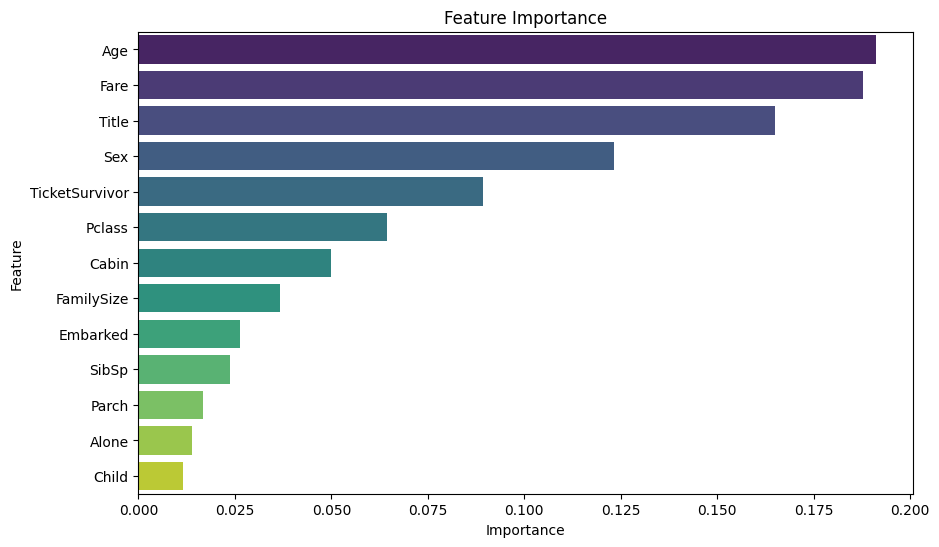

In [74]:
# Feature importance to know which factor leads to success
feature_importance = pd.DataFrame({'Feature': X.columns, 'Importance': model.feature_importances_})
feature_importance = feature_importance.sort_values(by='Importance', ascending=False)

# Plot feature importance
import matplotlib.pyplot as plt
import seaborn as sns
plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=feature_importance, palette='viridis')
plt.title('Feature Importance')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.show()